### ENLACE GOOGLE COLAB

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ccastro1992/clustering_rfm/blob/main/notebooks/ModeloFinal.ipynb)






# KMEANS

### **Instalacion Dependencias**

In [ ]:
import shutil
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # TRABAJAR EN EL ENTORNO DEL REPOSITORIO
    import os

    repo_name = "clustering_rfm"

    if os.path.exists(repo_name):
        shutil.rmtree('/content/clustering_rfm')

        %cd {'/content'}
        print(f"El directorio '{repo_name}' ya existe. Eliminando para clonar de nuevo...")
        shutil.rmtree(repo_name)

    #Clonar repositorio
    !git clone https://github.com/ccastro1992/{repo_name}.git

    # Entrar a la carpeta del repo
    %cd {repo_name}

In [ ]:
# ! pip install requests
# ! pip install scikit-learn-extra
# ! pip install pandas
# ! pip install matplotlib
# ! pip install seaborn

In [23]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from src import extract
from src import transformer
from src import load

### **Consulta API**

In [25]:
data = extract.get_ventas()

Datos para año 2020: 14517
Datos para año 2021: 19509
Datos para año 2022: 28196
Datos para año 2023: 27206
Datos para año 2024: 27279
Datos para año 2025: 18345


### **1. Carga de archivo de datos**

In [26]:
try:
    df = pd.DataFrame(data)
except Exception as e:
    print(f"Error al leer o inspeccionar el archivo: {e}")

len(df)

135052

### **2. Conversión de Datos**

In [ ]:
# df = transformer.convert_data_type(df)

### **3. Filtro de Datos**

In [33]:
df_filtered = transformer.clean_data(df)

Shape bruto: (135052, 18)


KeyboardInterrupt: 

### **4. Exploración de datos**

##### 4.1 Revisión Datos

In [28]:
# Función para revisar los datos del dataframe(Muetra la forma,tipo de datos, valores perdido, duplicados)
def check_dataframe(dataframe, head=15):
    print("Número de filas - Número de columnas".center(70, '-'))
    print(dataframe.shape)
    print('\n\n')

    print("Tipos de Datos".center(70, '-'))
    print(dataframe.dtypes)
    print('\n\n')

    print("Valores Nulos".center(70, '-'))
    print(dataframe.isnull().sum())
    print('\n\n')

    print("Valores Duplicados".center(70, '-'))
    print(dataframe.duplicated().sum())
    print('\n\n')

    print("Analisis Descriptivo".center(70, '-'))
    print(dataframe.describe())
    print('\n\n')

    print("INFO de dataframe".center(70, '-'))
    dataframe.info()

# Llamada a la función
check_dataframe(df_filtered)


-----------------Número de filas - Número de columnas-----------------
(131719, 19)



----------------------------Tipos de Datos----------------------------
numero_orden               object
cliente_id                 object
cliente                    object
fecha_vuelo        datetime64[ns]
pais                       object
estado                     object
ciudad                     object
estado_orden               object
vendedor                   object
producto_id                object
producto                   object
tallos                      int64
precio_unitario           float64
total                     float64
largo                       int64
agencia                    object
origen_cliente             object
usuario_id                 object
producto_upper             object
dtype: object



----------------------------Valores Nulos-----------------------------
numero_orden       0
cliente_id         0
cliente            0
fecha_vuelo        0
pais               0
est

In [ ]:
# df_filtered.to_csv('sample_data/df_filtered.csv', index=False)

##### 4.2 Analisis Previo

In [29]:
# Agrupacion de ventas por fecha
grouped = df_filtered.groupby('fecha_vuelo').sum('total').sort_values('fecha_vuelo', ascending=True)
grouped = grouped.reset_index()
grouped[['fecha_vuelo', 'total']]

,fecha_vuelo,total
0,2020-01-01,196.50
1,2020-01-02,280.50
2,2020-01-03,1210.73
3,2020-01-06,704.50
4,2020-01-08,142.50
...,...,...
1739,2025-11-16,6245.65
1740,2025-11-17,352.00
1741,2025-11-18,3469.86
1742,2025-11-19,2558.58


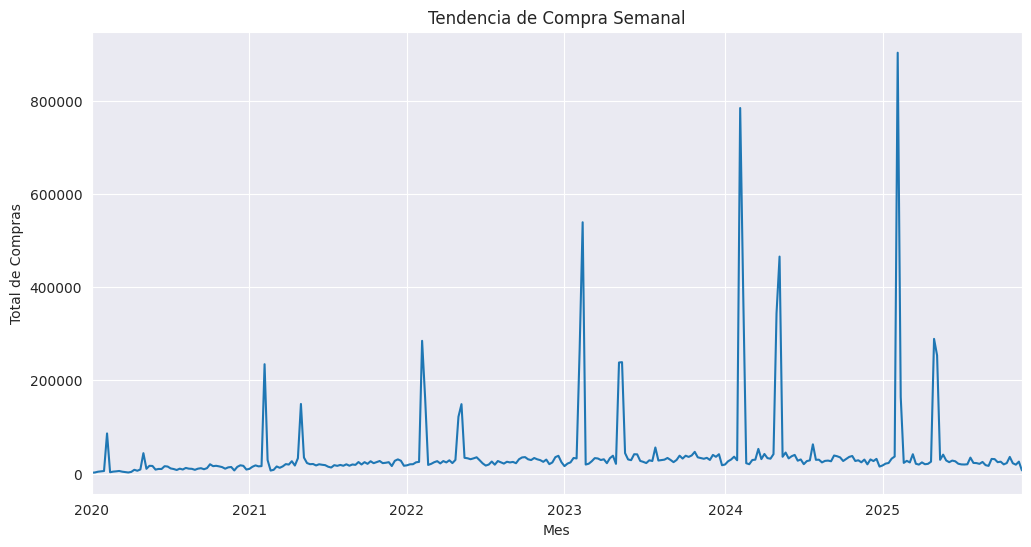

In [30]:
# Tendencia de venta a lo largo de los meses
monthly_trend = grouped.set_index('fecha_vuelo')

# Re-muestrear por mes y sumar el 'total'
monthly_trend = monthly_trend['total'].resample('W').sum()

# Gráfica
plt.figure(figsize=(12, 6))
monthly_trend.plot(kind='line')
plt.title('Tendencia de Compra Semanal')
plt.xlabel('Mes')
plt.ylabel('Total de Compras')
plt.grid(True)
plt.show()

### **5. RFM Estacional**

##### 5.1 Creación Variables

In [31]:
# Recency
fecha_max = df_filtered['fecha_vuelo'].max() #+ pd.Timedelta(days=1)
print(f"Fecha Máxima: {fecha_max.date()}")
recency_rfm = df_filtered.groupby('cliente_id')['fecha_vuelo'].max().reset_index()
recency_rfm['recency_dias'] = (fecha_max - recency_rfm['fecha_vuelo']).dt.days

# Frequency
frecuencia_rfm = df_filtered.groupby('cliente_id').agg(Frequency=('numero_orden', 'nunique')).reset_index()

# Monetary
monetary_rfm = df_filtered.groupby('cliente_id')['total'].sum().reset_index()
monetary_rfm.columns = ['cliente_id', 'total_gasto_cliente']

# Estacionalidad — semanas pico

# METODO 1
semanas_pico = [5,6,7,18,19]
matriz_semanas = df_filtered.pivot_table(
    index='cliente_id',
    columns='semana',
    values='numero_orden',
    aggfunc='count',
    fill_value=0
).reset_index()

# Peso de semanas pico
matriz_semanas['compras_pico'] = matriz_semanas[semanas_pico].sum(axis=1)
matriz_semanas['compras_totales'] = matriz_semanas.drop(columns=['cliente_id']).sum(axis=1)
matriz_semanas['peso_picos'] = (matriz_semanas['compras_pico'] / matriz_semanas['compras_totales']).fillna(0)


# METODO 2
# def es_fecha_pico(numero_semana):
#     if (numero_semana in [5,6,7]) or (numero_semana in [18,19]):
#         return 1
#     return 0

# df_filtered['peso_picos'] = df_filtered['semana'].apply(es_fecha_pico)
# estacional_rfm = df_filtered.groupby('cliente_id')['peso_picos'].mean().reset_index()
# estacional_rfm.columns = ['cliente_id', 'peso_picos']

Fecha Máxima: 2025-11-20


KeyError: 'semana'

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(matriz_semanas['peso_picos'], bins=20, kde=True, color='skyblue')
plt.title('Distribución del peso de compras en semanas pico')
plt.xlabel('Peso de semanas pico')
plt.ylabel('Cantidad de clientes')
plt.show()


In [ ]:
# Merge RFM + estacionalidad
# METODO 1
rfm_df = recency_rfm[['cliente_id','recency_dias']] \
    .merge(frecuencia_rfm, on='cliente_id') \
    .merge(monetary_rfm, on='cliente_id') \
    .merge(matriz_semanas[['cliente_id','peso_picos']], on='cliente_id')

# METODO 2
# rfm_df = recency_rfm[['cliente_id','recency_dias']] \
#     .merge(frecuencia_rfm, on='cliente_id') \
#     .merge(monetary_rfm, on='cliente_id') \
#     .merge(estacional_rfm[['cliente_id','peso_picos']], on='cliente_id')

rfm_df.rename(columns={'recency_dias': 'recency', 'Frequency': 'frequency', 'total_gasto_cliente': 'monetary', 'peso_picos': 'estacional'}, inplace=True)

# METODO 1
rfm_df['estacional'] = rfm_df['estacional']

# METODO 2
# rfm_df['estacional'] = rfm_df['estacional'].astype(int, errors='ignore')

In [ ]:
rfm_df.head(20)

In [ ]:
# rfm_df.to_csv('sample_data/rfm_df.csv', index=False)

##### 5.2 Analisis Estadistico

In [ ]:
rfm_df.head()

In [ ]:
describe_rfm = rfm_df.describe()
describe_rfm

###### Recencia


In [ ]:
# Grafico estadistico Recencia
describe_rfm['recency'].plot(kind='line', figsize=(8, 4), title='Recency')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(rfm_df['recency'], bins=30, kde=True)
plt.title('Distribución de la Recencia')
plt.xlabel('Recencia (Días desde la última compra)')
plt.ylabel('Cantidad de Clientes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=rfm_df['recency'])
plt.title('Boxplot de la Recencia')
plt.ylabel('Recencia (Días desde la última compra)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

###### Frecuencia

In [ ]:
# Grafico estadistico Frecuencia
describe_rfm['frequency'].plot(kind='line', figsize=(8, 4), title='Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=rfm_df['frequency'])
plt.title('Boxplot de la Frecuencia')
plt.ylabel('Frecuencia (Número de compras)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(rfm_df['frequency'], bins=30, kde=True)
plt.title('Distribución de la Frecuencia')
plt.xlabel('Frecuencia (Número de compras)')
plt.ylabel('Cantidad de Clientes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

###### Monetario

In [ ]:
# Grafico estadistico Monetario
describe_rfm['monetary'].plot(kind='line', figsize=(8, 4), title='Monetary')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=rfm_df['monetary'])
plt.title('Boxplot del Valor Monetario')
plt.ylabel('Valor Monetario ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(rfm_df['monetary'], bins=30, kde=True)
plt.title('Distribución del Valor Monetario')
plt.xlabel('Valor Monetario ($)')
plt.ylabel('Cantidad de Clientes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **6. Preparación Datos**

#### 6.1 Transformación y Escalamiento de Datos

In [ ]:
# Transformación Logaritmica
rfm_df['recency_log'] = -np.log1p(rfm_df['recency'])
rfm_df['frequency_log'] = np.log1p(rfm_df['frequency'])
rfm_df['monetary_log'] = np.log1p(rfm_df['monetary'])

# METODO 1
rfm_df['estacional_log'] = np.log1p(rfm_df['estacional'] * 100 + 1)  # amplifica importancia

# METODO 2
# rfm_df['estacional_log'] = np.log1p(rfm_df['estacional'])
rfm_df.head(10)

In [ ]:
# Seleccion de caracteristicas
cols_modelo = ['recency_log','frequency_log','monetary_log','estacional_log']

# Escalar
scaler = StandardScaler()
X = scaler.fit_transform(rfm_df[cols_modelo])

X

#### 6.2 Analisis Estadistico post transformacion logaritmica

In [ ]:
# Histograma para Recency (log-transformed)
plt.subplot(1, 1, 1)
sns.histplot(rfm_df['recency_log'], bins=30, kde=True)
plt.title('Distribución de Recency (Log-Transformed)')
plt.xlabel('Log(Recency)')
plt.ylabel('Cantidad de Clientes')



In [ ]:
# Histograma para Frequency (log-transformed)
plt.subplot(1, 1 ,1)
sns.histplot(rfm_df['frequency_log'], bins=30, kde=True)
plt.title('Distribución de Frequency (Log-Transformed)')
plt.xlabel('Log(Frequency)')
plt.ylabel('Cantidad de Clientes')



In [ ]:
# Histograma para Monetary (log-transformed)
plt.subplot(1, 1, 1)
sns.histplot(rfm_df['monetary_log'], bins=30, kde=True)
plt.title('Distribución de Monetary (Log-Transformed)')
plt.xlabel('Log(Monetary)')
plt.ylabel('Cantidad de Clientes')

plt.tight_layout()
plt.show()

### **7. Selección de k óptimo**

#### 7.1 Método del codo

In [ ]:
# Calculo la inercia para k de 2 a 10
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    print(f"{kmeans.inertia_}")


In [ ]:
# Graficar el Método del Codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (WCSS)')
plt.title('Método del Codo para encontrar k óptimo')
plt.xticks(K_range)
plt.grid(True)
plt.show()

#### 7.2 Método de Silhouette Score

In [ ]:
# Rango de k a probar
K_range = range(2, 11)
silhouette_scores = []

for k in K_range:
    # Entrenamos el modelo temporal
    kmeans = KMeans(n_clusters=k, random_state=24, n_init="auto")
    labels = kmeans.fit_predict(X)

    # Calculamos silueta
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    print(f"k={k} -> Silhouette Score: {score:.4f}")

# Grafico
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para diferentes k')
plt.grid(True)
plt.show()

### **8. Modelamiento KMEANS**

In [ ]:
# Aplicar K-Means con el K óptimo
k_optimal = 5

kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init="auto")
kmeans.fit(X)

# Asignar las etiquetas del cluster de nuevo al dataframe
rfm_df['cluster'] = kmeans.labels_

In [ ]:
# Analizar los Clusters
# Calcular la media de R, F, M, E para cada cluster
cluster_analysis = rfm_df.groupby('cluster')[['recency', 'frequency', 'monetary', 'estacional']].mean()
#
# Añadir el conteo de clientes en cada cluster
cluster_analysis['count'] = rfm_df['cluster'].value_counts()

# Reordenar columnas y ordenar por Valor Monetario para facilitar la interpretación
cluster_analysis = cluster_analysis[['count', 'recency', 'frequency', 'monetary', 'estacional']].sort_values(by='cluster', ascending=False)
cluster_analysis['estacional'] = cluster_analysis['estacional'].apply(lambda x: round(x, 2))
# Imprimir el análisis
print("Análisis de Clusters".center(70, '-'))
print(cluster_analysis)

### **9. Analisis de Resultados**

In [ ]:
# Silhouette Score
score = silhouette_score(X, kmeans.labels_)
print(f'Silhouette Score para k=5: {score:.4f}')

In [ ]:
# Davies-Bouldin
db_score = davies_bouldin_score(X, kmeans.labels_)
print(f'Davies-Bouldin Score para k=5: {db_score:.3f}')

In [ ]:
mapeo_clientes = {
    4: 'Clientes Wholesaler',
    3: 'Clientes Esporádicos',
    2: 'Cliente en Riesgo',
    1: 'Clientes Nuevos',
    0: 'Clientes Estacionales',
}
cluster_analysis = cluster_analysis.rename(index=mapeo_clientes)
cluster_analysis = cluster_analysis.reset_index()

# Mapear los números de cluster a los nombres descriptivos en el dataframe principal
rfm_df['Cluster_Name'] = rfm_df['cluster'].map(mapeo_clientes)

### **10. Visualización**

#### 10.1 Analisis de cluster

In [ ]:
plt.figure(figsize=(20, 16))

# Gráfico de Burbujas: Recencia vs. Monto (Tamaño = Cantidad de Clientes)
# Usamos escala logarítmica para el Monto porque el VIP es muy alto
plt.subplot(2, 2, 1)
sns.scatterplot(data=cluster_analysis, x='recency', y='monetary', size='count', hue='cluster', sizes=(200, 2000),
                legend=False, palette='viridis')

# Etiquetas para los puntos
for i in range(cluster_analysis.shape[0]):
    plt.text(cluster_analysis.recency[i] + 10, cluster_analysis.monetary[i], cluster_analysis.cluster[i],
             horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title('Mapa de Clusters: Recencia vs. Valor Monetario\n(El tamaño de la burbuja indica la cantidad de clientes)', fontsize=12)
plt.xlabel('Recencia (Días desde la última compra)')
plt.ylabel('Valor Monetario Promedio ($)')
plt.yscale('log')  # Escala logarítmica para ver mejor las diferencias
plt.grid(True, which="both", ls="--", alpha=0.5)

# 2. Gráfico de Barras: Frecuencia de Compra
plt.subplot(2, 2, 2)
sns.barplot(data=cluster_analysis.sort_values('frequency', ascending=False), x='cluster', y='frequency', legend=False, hue='cluster')
plt.title('Comparación de Frecuencia de Compra', fontsize=12)
plt.ylabel('Frecuencia Promedio (# Compras)')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 3. Gráfico de Barras: Cantidad de Clientes (Tamaño del Cluster)
plt.subplot(2, 2, 3)
sns.barplot(data=cluster_analysis.sort_values('count', ascending=False), x='cluster', y='count', legend=False, hue='cluster')
plt.title('Tamaño de cada Cluster (Cantidad de Clientes)', fontsize=12)
plt.ylabel('Número de Clientes')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Gráfico de Barras: Valor Monetario
plt.subplot(2, 2, 4)
sns.barplot(data=cluster_analysis.sort_values('monetary', ascending=False), x='cluster', y='monetary', legend=False, hue='cluster')
plt.title('Comparación de Gasto Promedio (Monetary)', fontsize=12)
plt.ylabel('Monto Promedio ($)')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### 10.2 Analisis de clientes en cluster

In [ ]:
# --- Visualización Individual de Clusters ---
# Obtener los nombres únicos de los clusters
cluster_names = rfm_df['Cluster_Name'].unique()

for cluster_name in cluster_names:
    if pd.isna(cluster_name):
        continue

    # Filtrar los datos para el cluster actual
    cluster_data = rfm_df[rfm_df['Cluster_Name'] == cluster_name]

    plt.figure(figsize=(12, 8))

    # Grafico de dispersión para el cluster actual
    sns.scatterplot(
        data=cluster_data,
        x='recency',
        y='monetary',
        size='frequency',
        hue='frequency',
        sizes=(50, 1000),
        palette='viridis',
        legend='auto'
    )

    plt.title(f'Análisis del Cluster: "{cluster_name}" ({len(cluster_data)} clientes)', fontsize=16)
    plt.xlabel('Recencia (Días desde la última compra)', fontsize=12)
    plt.ylabel('Valor Monetario Total ($)', fontsize=12)
    plt.grid(True, which="both", ls="--", alpha=0.5)

    # Anotar algunos clientes para identificación
    top_clients = cluster_data.nlargest(5, 'monetary')

    for index, row in top_clients.iterrows():
        plt.text(row['recency'] + 5, row['monetary'], str(int(row['cliente_id'])),
                 horizontalalignment='left', size='small', color='black', weight='semibold')

    plt.legend(title='Frecuencia')
    plt.show()

#### 10.3 Widget Interactivo para Filtro de Clientes por Cluster

In [ ]:
# Usar df_model y la columna cluster generada
cluster_options = sorted(rfm_df['cluster'].unique())

# Columnas que quieres mostrar en el promedio
cols_to_scale = ['recency', 'frequency', 'monetary', 'estacional']

dropdown = widgets.Dropdown(
    options=cluster_options,
    description='Cluster:',
    value=cluster_options[0]
)

def show_cluster_info(selected_cluster):
    df_cluster = rfm_df[rfm_df['cluster'] == selected_cluster]
    print("\n\n")

    print(f"Cluster seleccionado: {selected_cluster} - {mapeo_clientes.get(selected_cluster)}")
    print(f"Número de clientes: {df_cluster.shape[0]}")

    print("\n\n")
    print("Promedios de RFM".center(70, '-'))
    print(df_cluster[cols_to_scale].mean().round(2))

    print("\n\n")
    print("Primeros 10 clientes".center(70, '-'))
    print(df_cluster[['cliente_id', 'recency', 'frequency', 'monetary', 'estacional', 'cluster']].head(10))
    print("\n\n")

widgets.interact(show_cluster_info, selected_cluster=dropdown)

#### 10.4 Analisis de Componentes Principales

In [ ]:
# ---------------------------------------------------------
# PCA (asegurar que PC1 y PC2 existan en df_model)
# ---------------------------------------------------------
# Variables usadas para PCA (ajusta si tus columnas tienen otros nombres)
vars_pca = ['recency_log','frequency_log','monetary_log','estacional_log']

pca = PCA(n_components=2)
pcs = pca.fit_transform(rfm_df[vars_pca])

rfm_df['PC1'] = pcs[:, 0]
rfm_df['PC2'] = pcs[:, 1]

print("Columnas actuales del df_model:", rfm_df.columns)


In [ ]:
# ---------------------------------------------------------
# DISTRIBUCIONES POR CLUSTER
# ---------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14,10))
variables = ['recency_log','frequency_log','monetary_log','estacional_log']
titles = ['Recencia (log)', 'Frecuencia (log)', 'Monetario (log)', 'Estacional (log)']

for ax, var, title in zip(axes.flatten(), variables, titles):
    sns.boxplot(data=rfm_df, x='cluster', y=var, ax=ax)
    ax.set_title(f'Distribución de {title} por Cluster')

plt.tight_layout()
plt.show()

In [ ]:
# ---------------------------------------------------------
# INSIGHTS AUTOMÁTICOS POR CLUSTER
# ---------------------------------------------------------
print("\nINSIGHTS AUTOMÁTICOS POR CLUSTER\n")

def interpretar_cluster_stats(df_cluster):
    insights = []

    # Recency
    if df_cluster['recency'] < rfm_df['recency'].median():
        insights.append("Clientes recientes")
    else:
        insights.append("Clientes inactivos")

    # Frequency
    if df_cluster['frequency'] > rfm_df['frequency'].median():
        insights.append("Alta frecuencia")
    else:
        insights.append("Frecuencia baja/media")

    # Monetary
    if df_cluster['monetary'] > rfm_df['monetary'].median():
        insights.append("Alto valor monetario")
    else:
        insights.append("Gasto bajo/medio")

    # Estacionalidad
    if df_cluster['estacional'] > rfm_df['estacional'].median():
        insights.append("Muy estacionales (picos)")
    else:
        insights.append("No estacionales")

    return " / ".join(insights)


# Crear insights por cluster
cluster_insights = (
    rfm_df.groupby('cluster')[['recency','frequency','monetary','estacional']]
    .mean()
    .apply(interpretar_cluster_stats, axis=1)
)

for c, desc in cluster_insights.items():
    print(f"➡ Cluster {c}: {desc}")

In [ ]:
# ---------------------------------------------------------
# VISUALIZACIÓN DEL PCA CON ANOTACIONES
# ---------------------------------------------------------
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=rfm_df, x='PC1', y='PC2',
    hue='cluster', palette='tab10', alpha=0.7
)

plt.title("Visualización PCA de Clusters con Insights")

# Añadir anotaciones por cluster
for c, desc in cluster_insights.items():
    cx = rfm_df[rfm_df['cluster']==c]['PC1'].mean()
    cy = rfm_df[rfm_df['cluster']==c]['PC2'].mean()

    plt.text(
        cx, cy,
        f"Cluster {c}\n{desc}",
        fontsize=9,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="black"),
        ha='center'
    )

plt.show()

In [ ]:
# ---------------------------------------------------------
# Boxplots comparativos por cluster (RFM + estacionalidad)
# ---------------------------------------------------------
plt.figure(figsize=(14,10))

for i, var in enumerate(['recency','frequency','monetary','estacional']):
    plt.subplot(2,2,i+1)
    sns.kdeplot(data=rfm_df, x=var, hue='cluster', common_norm=False, fill=True)
    plt.title(f"Distribución de {var} por Cluster")

plt.tight_layout()
plt.show()


In [ ]:
# ---------------------------------------------------------
# Pairplot (scatter matrix) coloreado por cluster
# ---------------------------------------------------------
sns.pairplot(
    rfm_df[['recency','frequency','monetary','estacional','cluster']],
    hue='cluster',
    diag_kind='kde',
    palette='tab10'
)
plt.show()

In [ ]:
# ---------------------------------------------------------
# Agrupación normalizada Heatmap de medias normalizadas por cluster — PERFIL DE CLUSTER
# ---------------------------------------------------------
cluster_profile = (
    rfm_df.groupby("cluster")[["recency","frequency","monetary","estacional"]]
    .mean()
)

cluster_profile_norm = (cluster_profile - cluster_profile.min()) / (cluster_profile.max() - cluster_profile.min())

plt.figure(figsize=(8,5))
sns.heatmap(cluster_profile_norm, annot=True, cmap="Blues")
plt.title("Perfil Normalizado de Clusters")
plt.show()

In [ ]:
# ---------------------------------------------------------
# Donut chart del tamaño de cada cluster
# ---------------------------------------------------------
cluster_counts = rfm_df['cluster'].value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(
    cluster_counts,
    labels=[f"Cluster {i}" for i in cluster_counts.index],
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85
)

# círculo central
centre = plt.Circle((0,0),0.60,fc='white')
plt.gca().add_artist(centre)

plt.title("Distribución de Tamaños de Clusters")
plt.show()


In [ ]:
# ---------------------------------------------------------
# Radar Chart (Spider Plot) por cluster
# ---------------------------------------------------------
variables = ["recency","frequency","monetary","estacional"]
N = len(variables)

cluster_means = rfm_df.groupby("cluster")[variables].mean()

#Silhouette Plot (calidad de clustering)
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

sil_values = silhouette_samples(X, rfm_df['cluster'])
rfm_df['silhouette'] = sil_values

plt.figure(figsize=(8,5))
sns.boxplot(data=rfm_df, x='cluster', y='silhouette')
plt.title("Distribución de Silhouette por Cluster")
plt.show()



### **11. Inserción de Resultados**

In [ ]:
# Preparacion de JSON data para insertar
import json
final_df = rfm_df[['cliente_id','cluster','Cluster_Name']].rename(columns={'Cluster_Name':'cluster_descripcion'})
final_json = final_df.to_dict(orient="records")

data = {
    'data': final_json
}

data = json.dumps(data, indent=4)

load.set_client_cluster(data)